In [1]:
%matplotlib ipympl
%config InlineBackend.figure_format='retina'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import VBox, HBox, Output, Text
from IPython.display import display

from tesswcs import WCS
from tesswcs.utils import footprint
import astropy.units as u
from astropy.coordinates import SkyCoord
import pickle

from astropy.coordinates import get_sun
from astropy.time import Time

ecliptic_plane = SkyCoord(np.arange(0, 360, 1), np.arange(0, 360, 1)*0, unit='deg', frame='geocentricmeanecliptic').transform_to('icrs')
s = np.argsort(ecliptic_plane.ra.wrap_at(180 * u.deg).rad)
ecliptic_plane = ecliptic_plane[s]

In [4]:
r = pickle.load(open('allowable_pointings_grid.p', 'rb'))

# TESS Pointing Checker

The TESS spacecraft has criteria to determine what pointings are safe and power positive. This widget will help you visualize which pointings are allowable. The figure shows ecliptic coordinates, where the x axis shows the ecliptic longitude in degrees from the *anti-solar point*. (Here -180 degrees would be pointing directly at the Sun.) The y axis shows ecliptic latitude. The focal plane of TESS is shown overlaid, (note that Camera 1 has been highlighted as bolder than the other cameras, to give you an idea of which way round the spacecraft is.) Each observing sector for TESS is pointed towards the anti-solar point.

Pointings for TESS are prescribed by longitude, latitude, and roll. You can use the sliders to update these parameters and see how this impacts which regions of the sky will be observable. If the focal plane turns **blue**, that pointing does not violate TESS observing constraints. If the focal plane turns **red**, that pointing violates TESS observing constraints. 

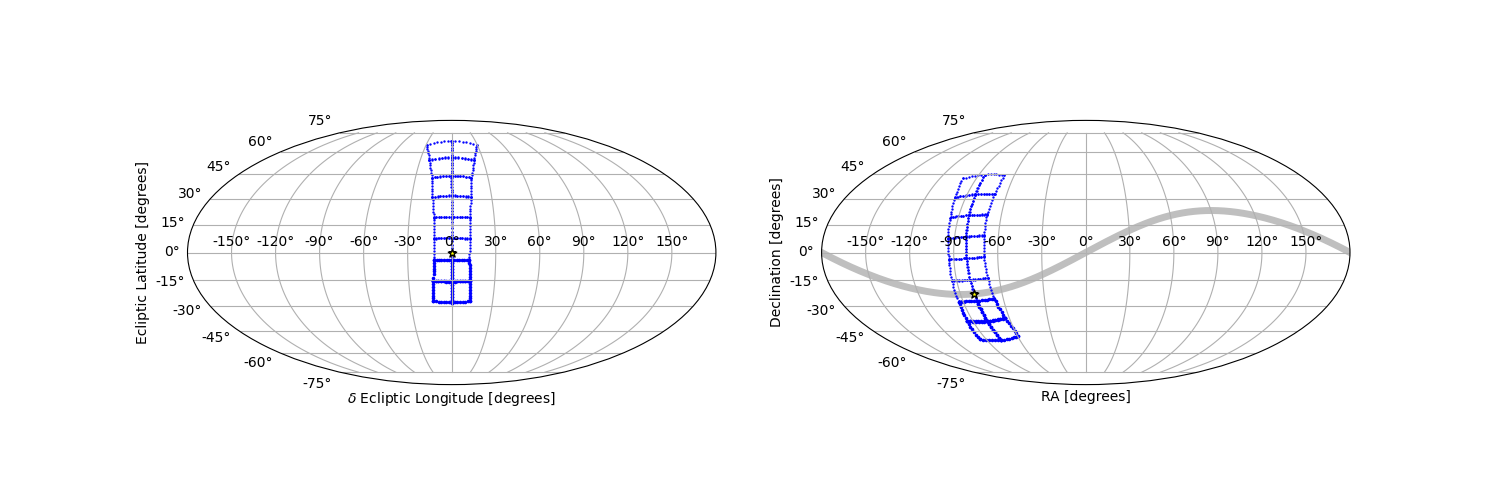

In [8]:
# Generate initial data
x = np.linspace(0, 10, 100)
y = np.sin(x)

# Create the figure and axis
fig = plt.figure(figsize=(15, 5))
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
fig.canvas.resizable = False


fp = footprint(npoints=8).T

ax = plt.subplot(121, projection="mollweide")
ax2 = plt.subplot(122, projection="mollweide")

output_log = widgets.Output()

def get_color(dlong=0, decl=20, roll=0):
    k = r[:, 2] == roll
    if (np.isclose(dlong, r[:, 0][k]).any()) & (np.isclose(decl, r[:, 1][k]).any()):
        return 'blue'
    else:
        return 'red'

def get_sun_position():
    t = Time.strptime(f"{month_dropdown.value:02}-2025", '%m-%Y')
    sun = get_sun(t).transform_to('geocentricmeanecliptic')
    return sun

# Create dropdown for months
month_dropdown = widgets.Dropdown(
    options=[('January', 1), ('February', 2), ('March', 3), ('April', 4), ('May', 5), ('June', 6), 
             ('July', 7), ('August', 8), ('September', 9), ('October', 10), ('November', 11), ('December', 12)],
    description='Month:',
    disabled=False,
    value=7,
)

    
def plot(dlong=0, decl=20, roll=0):
    ax.clear()  # Clear the previous plot
    ax.grid(True)
    ax.set(
        xlabel="$\delta$ Ecliptic Longitude [degrees]",
        ylabel="Ecliptic Latitude [degrees]",
    )
    

    ax2.clear()  # Clear the previous plot
    ax2.grid(True)
    ax2.set(
        xlabel="RA [degrees]",
        ylabel="Declination [degrees]",
    )
    ax2.plot(ecliptic_plane.ra.wrap_at(180 * u.deg).rad, ecliptic_plane.dec.rad, color='grey', zorder=-10, alpha=0.5, lw=5)
    sun = get_sun_position()
    antisun = SkyCoord(lon=sun.lon.deg - 180, lat=sun.lat.deg, unit='deg', frame='geocentricmeanecliptic')
    antisun_radec = antisun.transform_to('icrs')
    ax2.scatter(antisun_radec.ra.wrap_at(180 * u.deg).rad, antisun_radec.dec.rad, s=40, marker='*', color='yellow', zorder=10, edgecolor='k')
    ax.scatter(0, 0, s=40, marker='*', color='yellow', zorder=10, edgecolor='k')
    color = get_color(dlong, decl, roll)
    for camera in np.arange(1, 5):
        for ccd in np.arange(1, 5):
            wcs = WCS.predict(dlong, decl, roll, camera=camera, ccd=ccd)
            c = wcs.pixel_to_world(*fp)
            c = SkyCoord(lon=c.ra.deg, lat=c.dec.deg, unit='deg', frame='geocentricmeanecliptic')
            d = SkyCoord(lon=c.lon.deg + sun.lon.deg - 180, lat=c.lat.deg, unit='deg', frame='geocentricmeanecliptic')
            d = d.transform_to('icrs')
            if camera != 1:
                ax.scatter(c.lon.wrap_at(180 * u.deg).rad, c.lat.rad, c=color, s=0.5)
                ax2.scatter(d.ra.wrap_at(180 * u.deg).rad, d.dec.rad, c=color, s=0.5)
            else:
                ax.scatter(c.lon.wrap_at(180 * u.deg).rad, c.lat.rad, c=color, s=2.5)
                ax2.scatter(d.ra.wrap_at(180 * u.deg).rad, d.dec.rad, c=color, s=2.5)
            
    fig.canvas.draw_idle()

plot()
# Create a slider
slider1 = widgets.FloatSlider(value=0, min=-180, max=180, step=1, description='Longitude:')
slider2 = widgets.FloatSlider(value=20, min=-90, max=90, step=1, description='Latitude:')
slider3 = widgets.FloatSlider(value=0, min=-180, max=180, step=10, description='Roll:')

        
# Update function
def update_plot(change):
    plot(slider1.value, slider2.value, slider3.value)

# Link the sliders to the update function
slider1.observe(update_plot, names='value')
slider2.observe(update_plot, names='value')
slider3.observe(update_plot, names='value')
month_dropdown.observe(update_plot, names='value')

# Reset function
def reset_parameters(b):
    slider1.value = 0
    slider2.value = 20
    slider3.value = 0


# Create an Output widget to hold the figure
output = Output()

# Create a reset button
reset_button = widgets.Button(description='Reset')
reset_button.on_click(reset_parameters)

# with output:
#     display(fig)


# Arrange the plot and slider in a layout
ui = VBox([output, HBox([VBox([slider1, slider2, slider3, reset_button]), VBox([month_dropdown])]), output_log])
display(ui)